In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from itertools import groupby
from datetime import datetime, timedelta
from sklearn import metrics
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [6]:
# full_data = pd.read_csv("/content/drive/MyDrive/Capstone Bangkit/CPU_616.csv")
print('Opening docs...')
full_data = pd.read_csv("CPU_616.csv")
full_data = full_data.reset_index(drop=True)

In [7]:
# Converting CPU Usage to Float Datatype

full_data['cpu_used'] = (full_data['cpu_used'].str.replace('%', '').astype(float)) / 100
full_data = full_data[["created_at", "cpu_used"]]

In [8]:
full_data['created_at'] = pd.to_datetime(full_data['created_at'])

### Train-Test Split

In [9]:
# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(full_data.iloc[:, :-1], full_data.iloc[:, -1], 
                                                    test_size=0.2, shuffle=False)

### Modeling: ARIMA Univariate Time Series Forecasting

#### Stationarity Test

In [10]:
from statsmodels.tsa.stattools import adfuller

def adfullertest(data):
    result = adfuller(data)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-Value: {result[1]}')
    if result[1] < 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')

Augmented Dickey-Fuller (ADF test) merupakan pengujian statistik untuk mengukur stationarity data. Pengujian ini memiliki hipotesis nol (H0) bahwa data tidak stasioner. Umumnya jika p-value < 0.05, maka dianggap telah cukup bukti untuk menolak H0 dan menerima H1 bahwa data telah memiliki sifat stasioner.

In [11]:
# adfullertest(y_train)

ADF Statistics: -6.152189010007072
p-Value: 7.515677911141271e-08
Stationary


Hasil ADF Test menunjukkan p-value > 0.05. Dari nilai ini dapat ditarik kesimpulan bahwa data masih sangat jauh dari sifat stasioner untuk dapat dijadikan sebagai input ARIMA. Untuk itu, akan digunakan teknik differencing untuk menghilangkan trend dari data dan sekaligus membuat data menjadi lebih stasioner.

### ARIMA Model Hyperparameter Tuning

In [12]:
# Model Evaluation Functions
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(df_train_y, df_test_y, arima_order):
    # Prepare training dataset
    train_size = int(len(df_train_y))
    test_size = int(len(df_test_y))
    train, test = df_train_y, df_test_y
    # Make predictions
    model = ARIMA(df_train_y, order=arima_order)
    model_fit = model.fit()
    predictions = model_fit.forecast(test_size)
    # Calculate out of sample error
    rmse = (mean_squared_error(test, predictions))**0.5
    mae = mean_absolute_error(test, predictions)
    return rmse, mae
 
# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(df_train_y, df_test_y, p_values, d_values, q_values):
    best_score, best_cfg, best_mae = float("inf"), None, float("inf")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, mae = evaluate_arima_model(df_train_y, df_test_y, order)
                    if rmse < best_score:
                        best_score, best_cfg, best_mae = rmse, order, mae
                    print('ARIMA%s RMSE=%.3f MAE=%.3f' % (order,rmse,mae))
                except:
                    continue
    return best_cfg
    # print('Best ARIMA %s RMSE = %.3f MAE = %.3f' % (best_cfg, best_score, best_mae))
    

In [13]:
# HATI-HATI LAMA

# Evaluate parameters
# p_values = [1, 2]
# d_values = [0, 1]
# q_values = [1, 2]

p_values = [1]
d_values = [1]
q_values = [1, 2]

p, d, q = evaluate_models(y_train, y_test, p_values, d_values, q_values)

ARIMA(1, 1, 1) RMSE=0.024 MAE=0.010
ARIMA(1, 1, 2) RMSE=0.024 MAE=0.010


#### Forecasting Future Values of CPU Usage

In [14]:
model = ARIMA(full_data['cpu_used'], order=(p,d,q))
model_fit = model.fit()

In [15]:
# Set the number of days to be forecasted
forecasted_days = 1

# Specify the starting timestamp
latest_timestamp = full_data.iloc[-1, 0]
interval = timedelta(minutes=60)

# Specify the number of times to increment the timestamp
num_times = int(forecasted_days * 24 * (60/60))

# Create an empty list to store the timestamps
timestamps = []

# Generate the timestamps
for i in range(1, num_times+1):
    timestamps.append(latest_timestamp + i * interval)

In [16]:
# Self-predict the exiting data with the trained-model
fitting = model_fit.predict(start=0, end=len(full_data)-1)


# Forecasting new data
forecasts = model_fit.forecast(int(forecasted_days * 24 * (60/60))).T

# Outputting the forecasted data
forecasts = pd.DataFrame({'Timestamp': timestamps, 'Forecasts': forecasts})

,Timestamp,Forecasts
140353,2023-05-04 04:25:00,0.074747
140354,2023-05-04 05:25:00,0.073141
140355,2023-05-04 06:25:00,0.074744
140356,2023-05-04 07:25:00,0.073144
140357,2023-05-04 08:25:00,0.074742
140358,2023-05-04 09:25:00,0.073147
140359,2023-05-04 10:25:00,0.074739
140360,2023-05-04 11:25:00,0.073150
140361,2023-05-04 12:25:00,0.074736
140362,2023-05-04 13:25:00,0.073153


In [17]:
# import pickle
# pickle.dump(predictions, open('predictions.pkl', 'wb'))

#### Visualizing Back-Normalized Forecasted Values

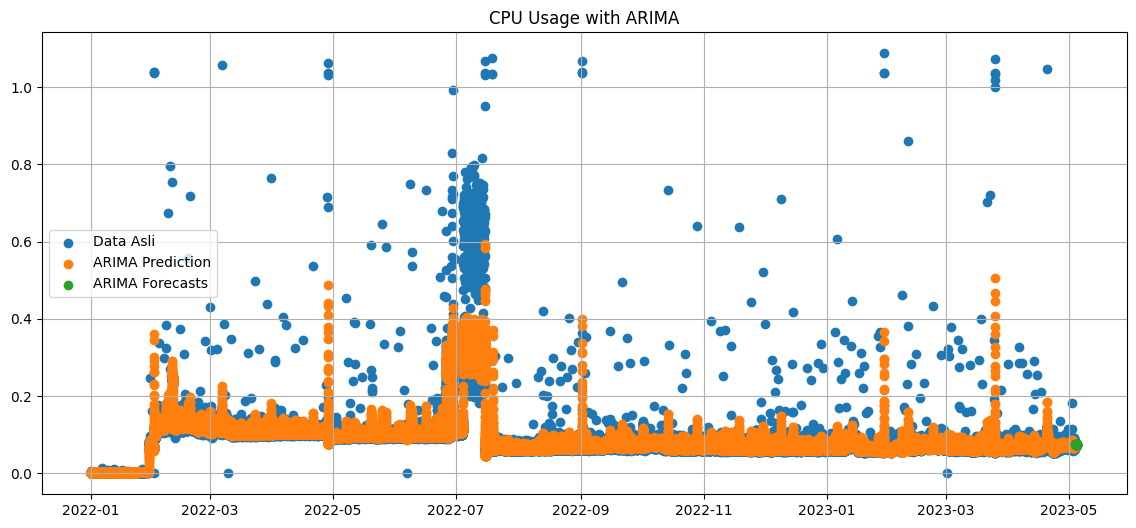

In [18]:
# fig, ax = plt.subplots(1,1,figsize=(14,6))

# ax.scatter(full_data["created_at"], 
#            full_data["cpu_used"], 
#            label='Data Asli')

# ax.scatter(full_data["created_at"], 
#            fitting, 
#            label='ARIMA Prediction')

# ax.scatter(forecasts['Timestamp'], 
#            forecasts['Forecasts'], 
#            label='ARIMA Forecasts')

# plt.title('CPU Usage with ARIMA')
# plt.grid()
# plt.legend()

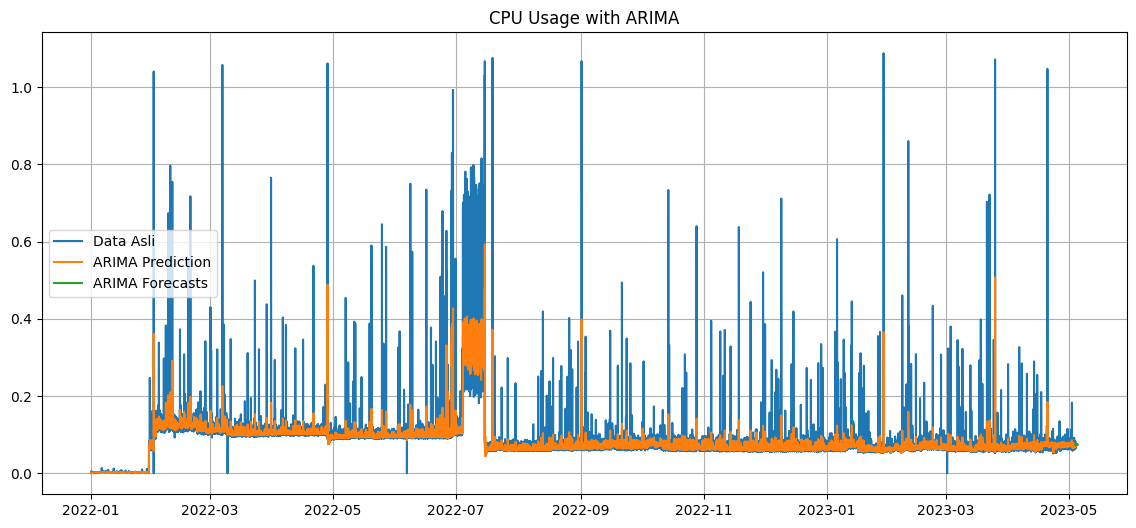

In [19]:
# fig, ax = plt.subplots(1,1,figsize=(14,6))

# ax.plot(full_data["created_at"], 
#            full_data["cpu_used"], 
#            label='Data Asli')

# ax.plot(full_data["created_at"], 
#            fitting, 
#            label='ARIMA Prediction')

# ax.plot(forecasts['Timestamp'], 
#            forecasts['Forecasts'], 
#            label='ARIMA Forecasts')

# plt.title('CPU Usage with ARIMA')
# plt.grid()
# plt.legend()

## Additional Resource Prediction

In [20]:
# Search for CPU Usage percentages that are equal or more than 80%
current_core = 1
core_upgrade_options = {1: 2,
                        2: 4,
                        4: 6,
                        6: 8}

need_add = forecasts[forecasts['Forecasts'] >= 0.8]
need_add['Forecasts'] = (need_add['Forecasts']*100).round(4)
need_add['Forecasts'] = need_add['Forecasts'].astype(str) + '%'

if need_add.empty:
  print(f"Your forecasted CPU Usage value in 30 days ahead will be {forecasts['Forecasts'].iloc[-1] * 100:.4f}%")
else:
  print("Based on your usage pattern, you will reach more than 80% of your current available CPU core!")
  print(f"We recommend you to upgrade your CPU core to {core_upgrade_options[current_core]} CPU core(s)")
  print()
  print(need_add)

Based on your usage pattern, you will reach more than 80% of your current available CPU core!
We recommend you to upgrade your CPU core to 2 CPU core(s)

                 Timestamp Forecasts
140353 2023-05-04 04:25:00   7.4747%
140355 2023-05-04 06:25:00   7.4744%
140357 2023-05-04 08:25:00   7.4742%


In [ ]:
# Saving the list of forecasted data which will exceed current resource package
need_add.to_csv('exceeded_resource_data.csv', index=False)

## Anomaly Detection

In [21]:
df_dummy = full_data.copy()
df_dummy["fittings"] = fitting
df_dummy['Error'] = df_dummy['cpu_used'] - df_dummy['fittings']

### Dynamic Thresholding + Consecutive Occurences

In [22]:
data_copy = df_dummy.copy()
std_coef = 1.5  # Besar standar deviasi penyimpangan dari mean window
window = int(6)  # Windowing
consecutive = 3  # Frekuensi minimum kemunculan outliers berturut-turut

data_copy['mean'] = pd.Series(data_copy['Error'].rolling(window=window).mean())
data_copy['std'] = pd.Series(data_copy['Error'].rolling(window=window).std())
data_copy['up_thres'] = pd.Series(data_copy['Error'].rolling(window=window).mean()) \
                    + (std_coef * pd.Series(data_copy['Error'].rolling(window=window).std()))
data_copy['down_thres'] = pd.Series(data_copy['Error'].rolling(window=window).mean()) \
                    - (std_coef * pd.Series(data_copy['Error'].rolling(window=window).std()))

out_index = data_copy.index[(data_copy['Error'] > data_copy['up_thres']) | (data_copy['Error'] < data_copy['down_thres'])]

data_copy['outliers_bool'] = [False for _ in range(len(data_copy))]
data_copy['outliers_bool'][out_index] = True

In [23]:
greater_th = [list(g) for k, g in groupby(data_copy['outliers_bool']==True)]

for i in range(len(greater_th)):
  if greater_th[i].count(True) < consecutive:
    greater_th[i] = [False for _ in greater_th[i]]

greater_th = pd.DataFrame({"Outliers": [element for sublist in greater_th for element in sublist]})
updated_out_index = greater_th[greater_th["Outliers"]==True].index

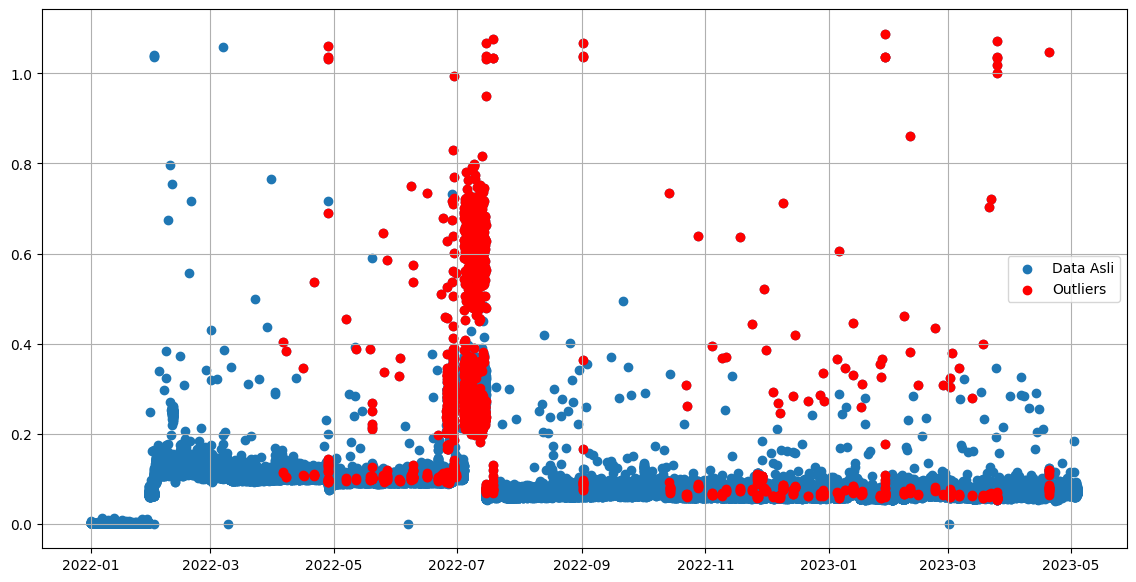

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(14,7))
# ax.scatter(data_copy['created_at'], data_copy['cpu_used'], label='Data Asli')
# ax.scatter(data_copy['created_at'][updated_out_index], data_copy['cpu_used'][updated_out_index], c='Red', label='Outliers')
# plt.grid()
# plt.legend()

In [31]:
data_anomaly_labeled = data_copy[['created_at', 'cpu_used']]
data_anomaly_labeled['is_anomaly'] = [False for _ in range(len(data_anomaly_labeled))]
data_anomaly_labeled['is_anomaly'].iloc[updated_out_index] = True
data_anomaly_labeled['cpu_used'] = (data_anomaly_labeled['cpu_used']*100).round(4).astype(str) + "%"

,created_at,cpu_used,is_anomaly
0,2022-01-01 00:00:00,0.2%,False
1,2022-01-01 00:05:00,0.2%,False
2,2022-01-01 00:10:00,0.19%,False
3,2022-01-01 00:15:00,0.2%,False
4,2022-01-01 00:20:00,0.2%,False
...,...,...,...
140348,2023-05-04 03:05:00,6.85%,False
140349,2023-05-04 03:10:00,7.43%,False
140350,2023-05-04 03:15:00,7.73%,False
140351,2023-05-04 03:20:00,7.24%,False


In [ ]:
# Saving Anomaly Labeled Data
data_anomaly_labeled.to_csv('anomaly_detection.csv', index=False)

## Cost Projection

In [33]:
forecasts_df = forecasts.copy()

,Timestamp,Forecasts
140353,2023-05-04 04:25:00,0.074747
140354,2023-05-04 05:25:00,0.073141
140355,2023-05-04 06:25:00,0.074744
140356,2023-05-04 07:25:00,0.073144
140357,2023-05-04 08:25:00,0.074742
140358,2023-05-04 09:25:00,0.073147
140359,2023-05-04 10:25:00,0.074739
140360,2023-05-04 11:25:00,0.073150
140361,2023-05-04 12:25:00,0.074736
140362,2023-05-04 13:25:00,0.073153


In [43]:
current_core = 1
core_upgrade_options = {1: 2,
                        2: 4,
                        4: 6,
                        6: 8}

cost_options = {1: round(85000/720, 2),
                2: round(200000/720, 2),
                4: round(700000/720, 2),
                6: round(720000/720, 2),
                8: round(1500000/720, 2)}

forecasts_df['Core'] = current_core
forecasts_df['Core'].loc[forecasts_df['Forecasts'] >= 0.8] = core_upgrade_options[current_core]
forecasts_df['Cost'] = forecasts_df['Core'].map(cost_options)

total_cost = forecasts_df['Cost'].sum()

In [47]:
# forecasts_df

,Timestamp,Forecasts,Core,Cost
140353,2023-05-04 04:25:00,0.074747,1,118.06
140354,2023-05-04 05:25:00,0.073141,2,277.78
140355,2023-05-04 06:25:00,0.074744,1,118.06
140356,2023-05-04 07:25:00,0.073144,2,277.78
140357,2023-05-04 08:25:00,0.074742,1,118.06
140358,2023-05-04 09:25:00,0.073147,2,277.78
140359,2023-05-04 10:25:00,0.074739,1,118.06
140360,2023-05-04 11:25:00,0.073150,2,277.78
140361,2023-05-04 12:25:00,0.074736,1,118.06
140362,2023-05-04 13:25:00,0.073153,1,118.06


In [46]:
print(f'Total Estimated Forecasted Cost: Rp{total_cost:.2f}')

Total Estimated Forecasted Cost: Rp3472.32


In [ ]:
# Saving total estimated cost projection
forecasts_df.to_csv('cost_projection.csv', index=False)